In [106]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [107]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [108]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [109]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [110]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [111]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [112]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [113]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [28]:
# Get a list of column names and types for measurement table
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [50]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [53]:
latest = dt.date(2017, 8, 23).isoformat()
latest

'2017-08-23'

In [39]:
# Calculate the date one year from the last date in data set.
year_diff = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("One year earlier: ", year_diff)

One year earlier:  2016-08-23


In [54]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.

precip = session.query(Measurement.date, Measurement.prcp).\
     filter((Measurement.date <= latest) & (Measurement.date >= year_diff)).\
     order_by(Measurement.date.desc()).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precip).set_index('date').dropna(how='any')
precip_df = precip_df.rename(columns={'prcp':'precipitation'})
precip_df

,precipitation
date,
2017-08-23,0.00
2017-08-23,0.00
2017-08-23,0.08
2017-08-23,0.45
2017-08-22,0.00
...,...
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02


In [ ]:
#precip_df.plot(rot=60, colormap='viridis', figsize=(16,8))

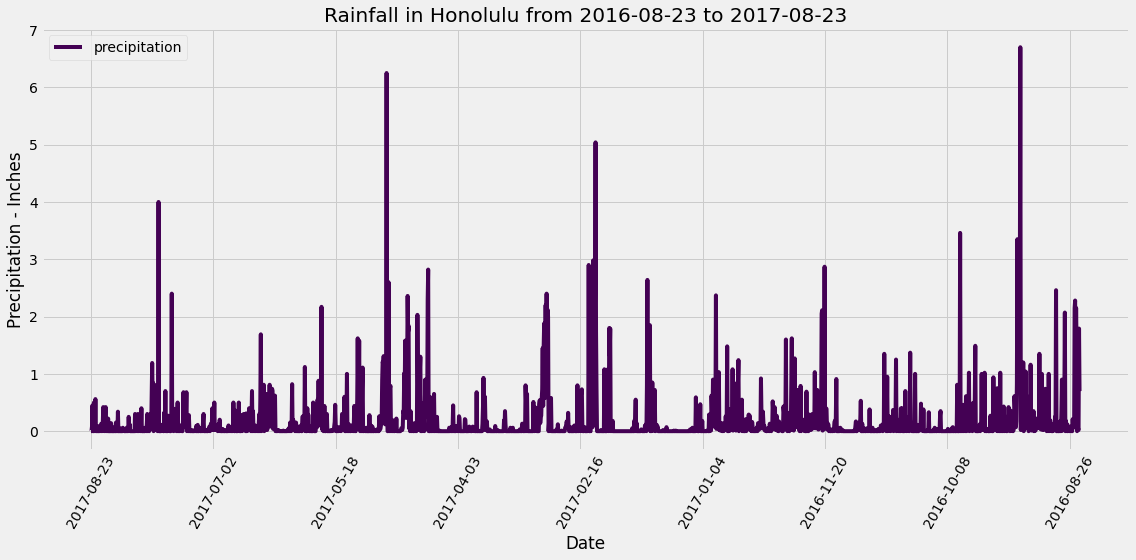

In [117]:
# Use Pandas Plotting with Matplotlib to plot the data
# x_axis = precip_df.index.to_list()
# precip_counts = precip_df['precipitation'].value_counts()
# y_axis = np.arange(len(precip_counts))
# plt.bar(x_axis, y_axis)
# plt.get_cmap('viridis')

precip_df.plot(rot=60, colormap='viridis', figsize=(16,8))
plt.title(f"Rainfall in Honolulu from {year_diff} to {latest}")
plt.xlabel("Date")
#plt.xticks(rotation=60,)
plt.ylabel("Precipitation - Inches")
plt.legend(loc="best")
#plt.figure(figsize=(16,8))
plt.tight_layout()
plt.show()

In [48]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [55]:
# Get a list of column names and types for station table
columns = inspector.get_columns('station')
for col in columns:
    print(col['name'], col["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [87]:
engine.execute('SELECT * FROM station').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [56]:
# Design a query to calculate the total number stations in the dataset
session.query(func.count(Station.station)).all()

[(9)]

In [70]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
sel = [Measurement.station, func.count(Measurement.station)]
activity = session.query(*sel).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [82]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Hint: You will need to use a function such as func.min, func.max, func.avg, and func.count in your queries.
most_active = 'USC00519281'
sel = [func.min(Measurement.tobs),
      func.max(Measurement.tobs),
      func.avg(Measurement.tobs)]
active_stats = session.query(*sel).filter(Measurement.station == most_active).all()
active_stats
# print(f"Min Temp: {func.min(Measurement.tobs)}")
# print(f"Max Temp: {func.max(Measurement.tobs)}")
# print(f"Average Temp: {func.avg(Measurement.tobs)}")

[(54.0, 85.0, 71.66378066378067)]

In [77]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station
active_tobs = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == most_active).\
    filter((Measurement.date <= latest) & (Measurement.date >= year_diff)).\
    order_by(Measurement.date.desc()).all()

tobs_df = pd.DataFrame(active_tobs).set_index('date').dropna(how='any')
tobs_df = tobs_df.rename(columns={'tobs':'temp observation'})
tobs_df

,temp observation
date,
2017-08-18,79.0
2017-08-17,76.0
2017-08-16,76.0
2017-08-15,77.0
2017-08-14,77.0
...,...
2016-08-27,75.0
2016-08-26,80.0
2016-08-25,80.0


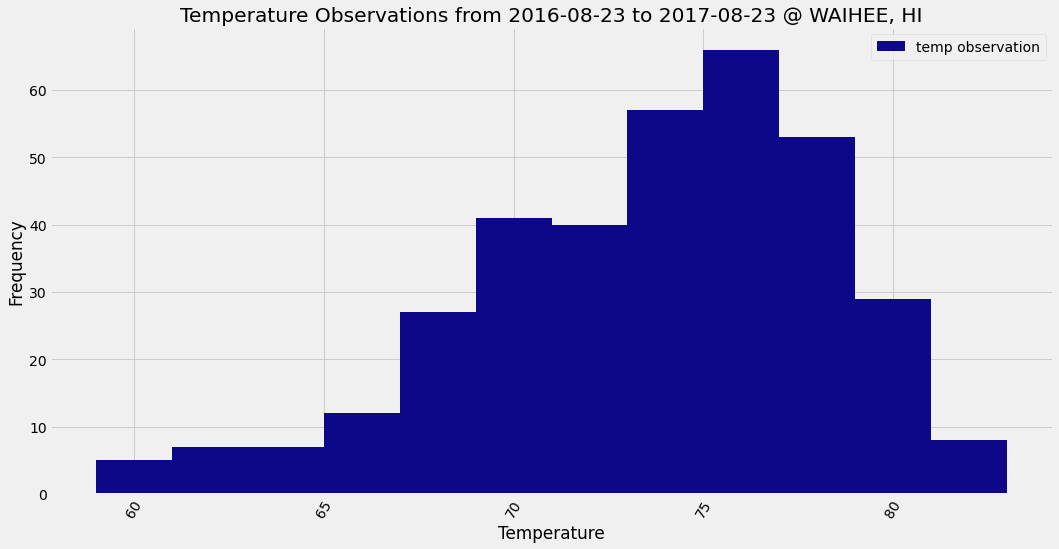

In [89]:
# Plot the results as a histogram using bins=12
tobs_df.plot.hist(rot=60, colormap='plasma', bins=12, figsize=(16,8))
plt.title(f"Temperature Observations from {year_diff} to {latest} @ WAIHEE, HI")
plt.xlabel("Temperature")
plt.show()

# Close session

In [ ]:
# Close Session
session.close()